## Import Modules

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

2024-12-01 00:33:11.100812: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732993391.114011   19898 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732993391.117667   19898 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-01 00:33:11.133046: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load the Dataset

In [2]:
TRAIN_DIR = 'facial-expression-dataset/train/train/'
TEST_DIR = 'facial-expression-dataset/test/test/'

In [3]:
def load_dataset(directory):
    image_paths = []
    labels = []
    
    for label in os.listdir(directory):
        for filename in os.listdir(directory+label):
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)
            
        print(label, "Completed")
        
    return image_paths, labels

In [4]:
## convert into dataframe
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)
# shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
train.head()

neutral Completed
disgust Completed
surprise Completed
happy Completed
sad Completed
angry Completed
fear Completed


,image,label
0,facial-expression-dataset/train/train/fear/Tra...,fear
1,facial-expression-dataset/train/train/happy/Tr...,happy
2,facial-expression-dataset/train/train/happy/Tr...,happy
3,facial-expression-dataset/train/train/sad/Trai...,sad
4,facial-expression-dataset/train/train/neutral/...,neutral


In [5]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR)
test.head()

neutral Completed
disgust Completed
surprise Completed
happy Completed
sad Completed
angry Completed
fear Completed


,image,label
0,facial-expression-dataset/test/test/neutral/Pr...,neutral
1,facial-expression-dataset/test/test/neutral/Pr...,neutral
2,facial-expression-dataset/test/test/neutral/Pu...,neutral
3,facial-expression-dataset/test/test/neutral/Pr...,neutral
4,facial-expression-dataset/test/test/neutral/Pr...,neutral


## Exploratory Data Analysis

<Axes: xlabel='count', ylabel='label'>

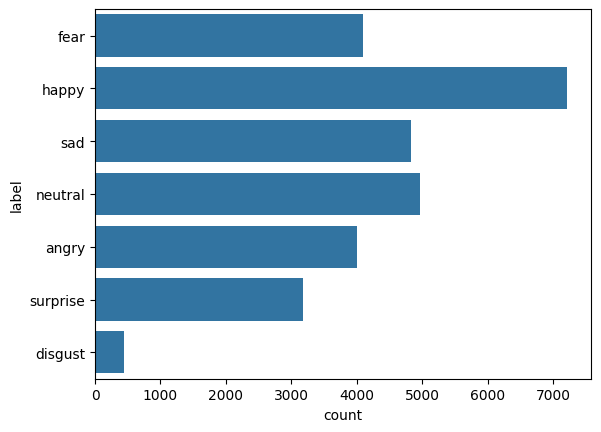

In [6]:
sns.countplot(train['label'])

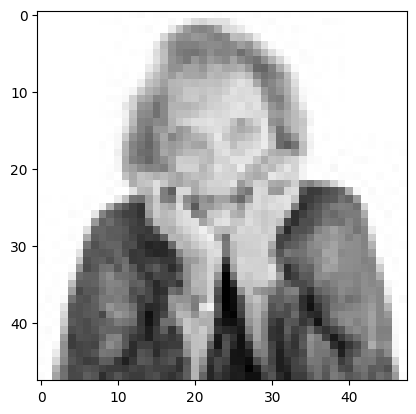

In [7]:
from PIL import Image
img = Image.open(train['image'][0])
plt.imshow(img, cmap='gray');

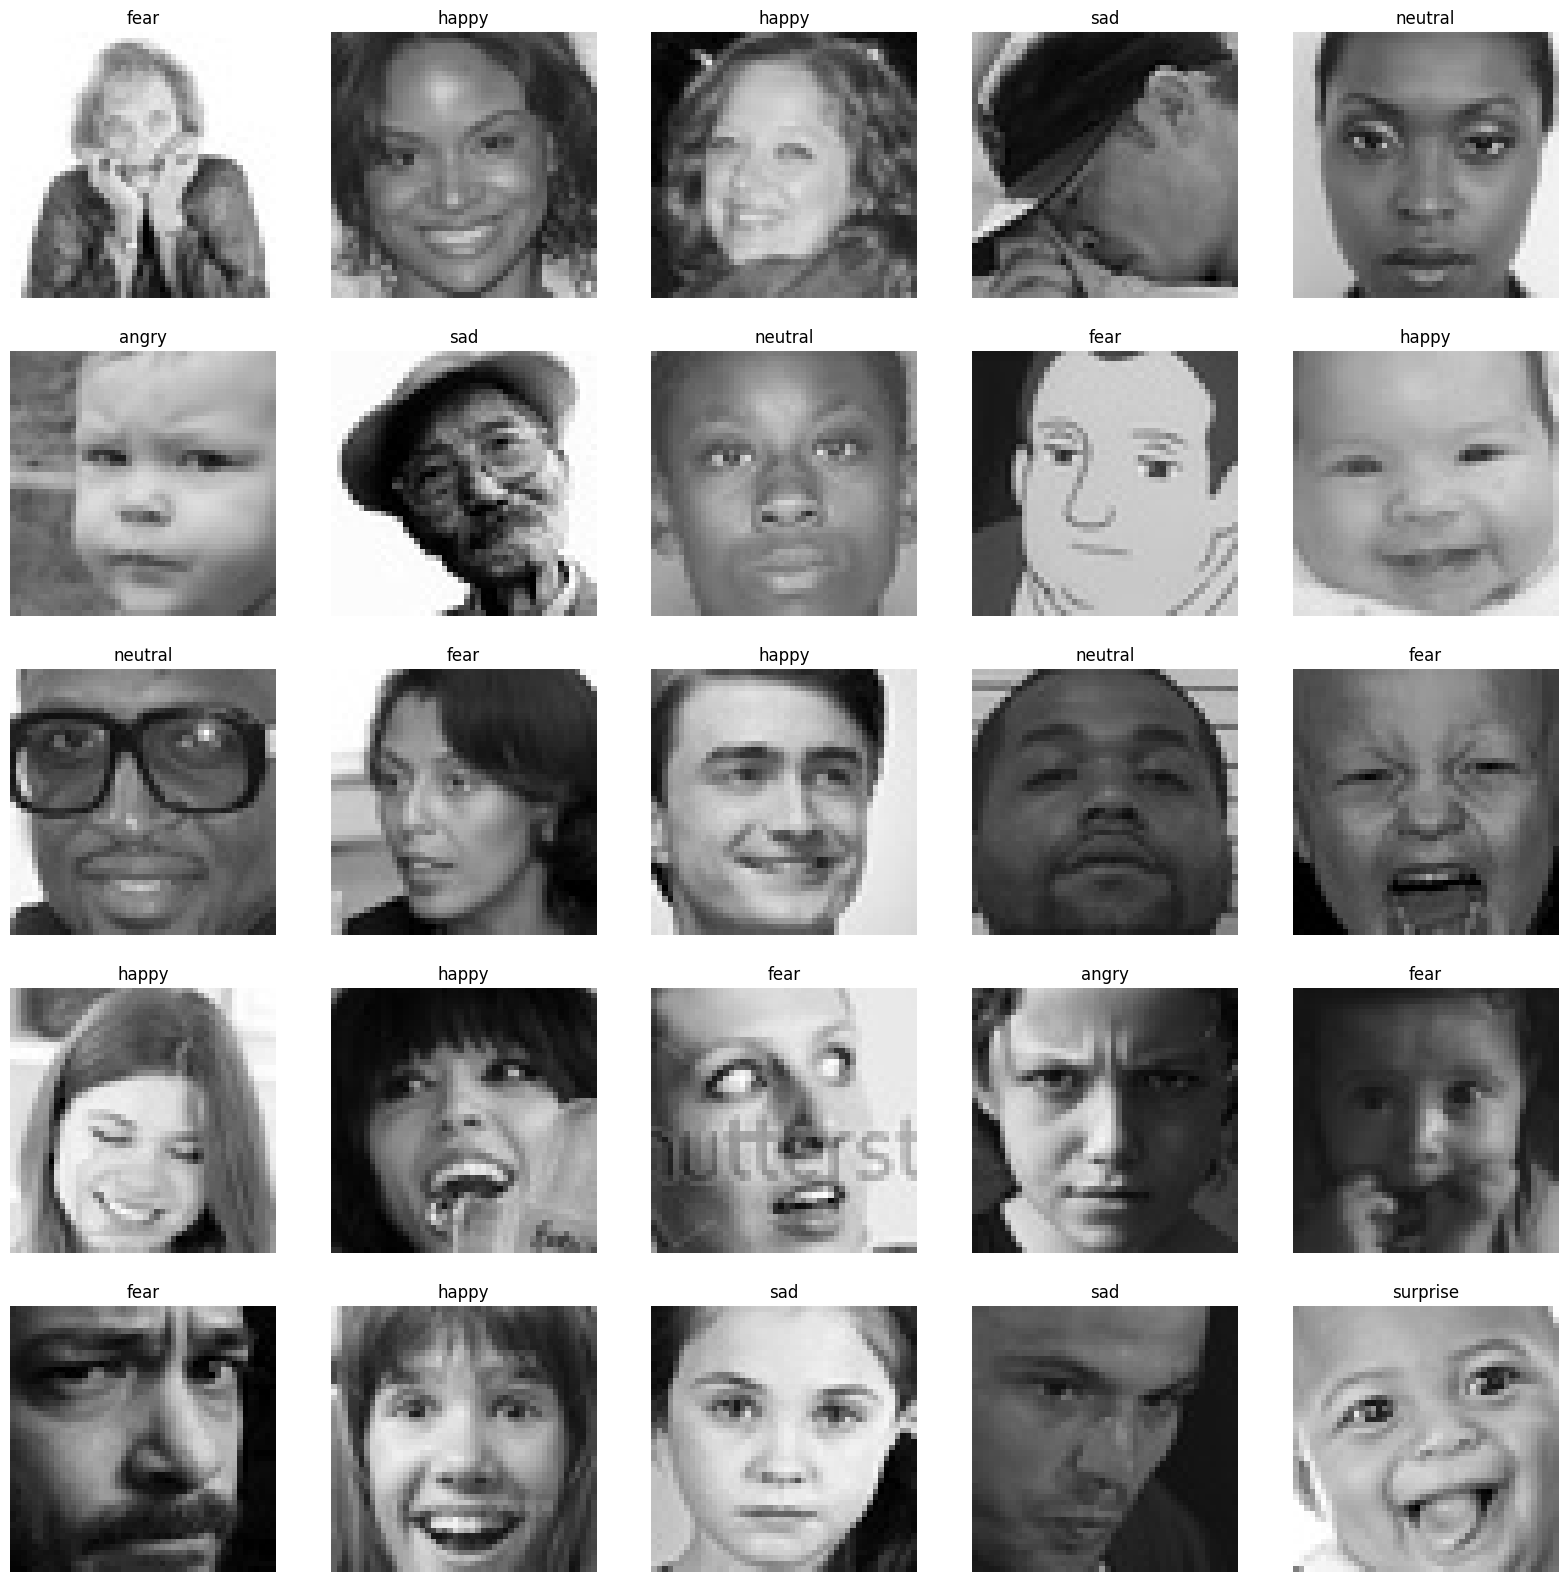

In [8]:
# to display grid of images
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, file, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

## Feature Extraction

In [9]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale')
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)
    return features

train_features = extract_features(train['image'])

  0%|          | 0/28709 [00:00<?, ?it/s]

In [10]:
test_features = extract_features(test['image'])

  0%|          | 0/7178 [00:00<?, ?it/s]

In [11]:
## normalize the image
x_train = train_features/255.0
x_test = test_features/255.0

In [12]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [13]:
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [14]:
y_train[0]

array([0., 0., 1., 0., 0., 0., 0.])

In [15]:
# config
input_shape = (48, 48, 1)
output_class = 7

## Model Creation

In [16]:
model = Sequential()
# convolutional layers
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
# fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
# output layer
model.add(Dense(output_class, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

I0000 00:00:1732993396.791933   19898 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9509 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


In [17]:
# train the model
history = model.fit(x=x_train, y=y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100


I0000 00:00:1732993401.450106   19982 service.cc:148] XLA service 0x643ec6e94af0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732993401.450349   19982 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-12-01 00:33:21.494883: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732993401.691435   19982 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-12-01 00:33:22.453415: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3063', 12 bytes spill stores, 16 bytes spill loads



  5/225 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.1691 - loss: 1.9497

I0000 00:00:1732993409.329957   19982 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.2333 - loss: 1.8410

2024-12-01 00:33:42.104561: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_112_0', 228 bytes spill stores, 228 bytes spill loads

2024-12-01 00:33:42.249088: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_112_0', 768 bytes spill stores, 720 bytes spill loads



225/225 ━━━━━━━━━━━━━━━━━━━━ 26s 73ms/step - accuracy: 0.2334 - loss: 1.8409 - val_accuracy: 0.2470 - val_loss: 1.8140
Epoch 2/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.2535 - loss: 1.8038 - val_accuracy: 0.2885 - val_loss: 1.7428
Epoch 3/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.2939 - loss: 1.7281 - val_accuracy: 0.3735 - val_loss: 1.6131
Epoch 4/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.3574 - loss: 1.6156 - val_accuracy: 0.4436 - val_loss: 1.4302
Epoch 5/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.4161 - loss: 1.4949 - val_accuracy: 0.4720 - val_loss: 1.3714
Epoch 6/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.4457 - loss: 1.4345 - val_accuracy: 0.4776 - val_loss: 1.3289
Epoch 7/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.4628 - loss: 1.3935 - val_accuracy: 0.4996 - val_loss: 1.2797
Epoch 8/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.4792 - loss: 1.3544 - val_accurac

In [ ]:
# !pip install 'tensorflow[and-cuda]'

## Plot the Results

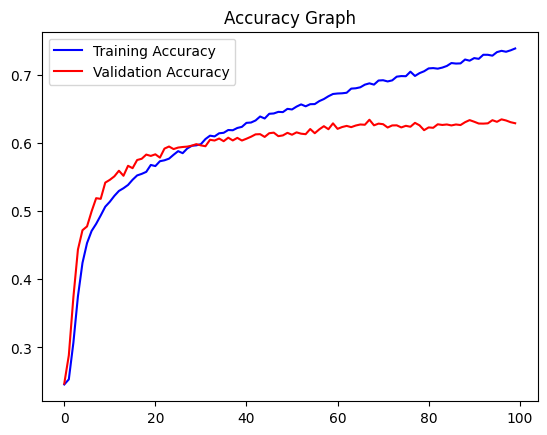

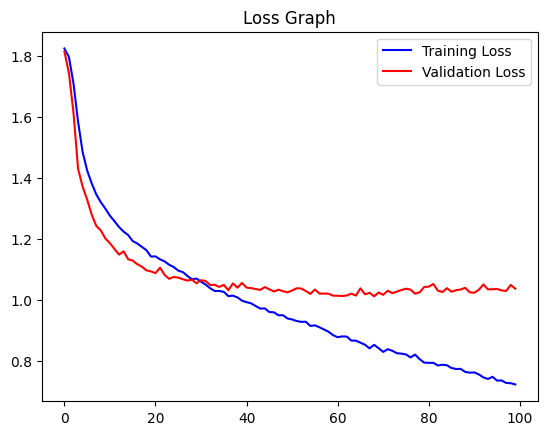

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()

plt.show()

## Test with Image Data

Original Output: surprise
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
Predicted Output: surprise


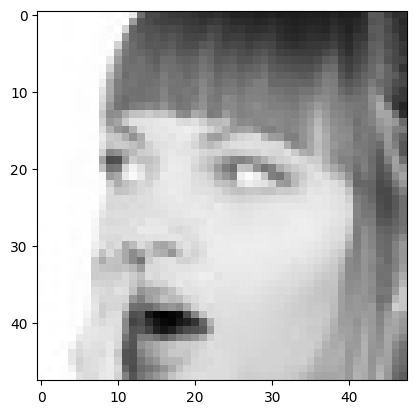

In [19]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

Original Output: fear
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted Output: fear


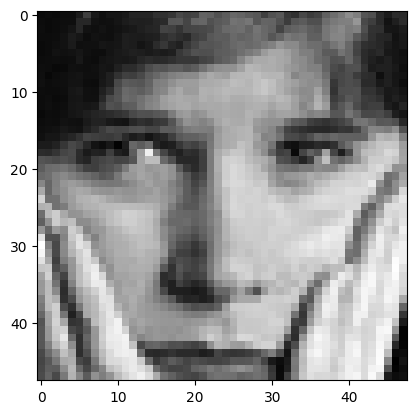

In [20]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

Original Output: fear
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted Output: sad


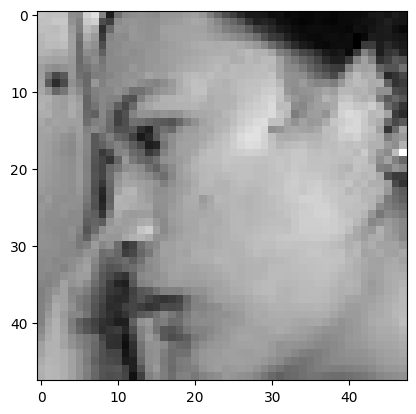

In [21]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');